In [36]:
import numpy as np
import pandas as pd
from pathlib import Path

In [74]:
import sys
!{sys.executable} -m pip install -U pandas

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-1.4.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipfx 1.0.5 requires pandas<=0.25.3,>=0.25.1, but you have pandas 1.4.3 which is incompatible.
anndata 0.8.0 requires h5py>=3, but you have h5py 2.10.0 which is incompatible.


In [8]:
import sys
!{sys.executable} -m pip install ipfx

Defaulting to user installation because normal site-packages is not writeable
  Using cached IPFX-1.0.5-py2.py3-none-any.whl (1.9 MB)
  Using cached matplotlib-3.5.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached dictdiffer-0.9.0-py2.py3-none-any.whl (16 kB)
  Using cached h5py-2.10.0-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)
  Using cached pyabf-2.2.8-py3-none-any.whl
  Using cached methodtools-0.4.5-py3-none-any.whl
  Using cached watchdog-2.1.9-py3-none-manylinux2014_x86_64.whl (78 kB)
  Using cached argschema-1.17.5-py2.py3-none-any.whl (18 kB)
  Using cached PyYAML-5.4.1-cp38-cp38-manylinux1_x86_64.whl (662 kB)
  Using cached allensdk-2.13.5-py3-none-any.whl (1.9 MB)
  Using cached pg8000-1.29.1-py3-none-any.whl (34 kB)
  Using cached pynwb-1.5.1-py2.py3-none-any.whl (98 kB)
  Using cached simplejson-3.17.6-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (139 kB)
  Using cached marshmallow-3.0.0rc6-py2.p

In [75]:
from ipfx.feature_extractor import (SpikeFeatureExtractor, SpikeTrainFeatureExtractor)
import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps
from ipfx.data_set_features import extract_data_set_features
from ipfx.error import FeatureError

import matplotlib.pyplot as plt

In [116]:
def process_dataset_sweeps(data_set):
    drop_failed_sweeps(data_set)
    long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names) 
    long_square_table = long_square_table[long_square_table['passed'] == True]
    long_square_table = long_square_table[long_square_table['clamp_mode'] == "CurrentClamp"]
    
    good_sweeps = list()
    for i in long_square_table.sweep_number:
        try:
            curr_sweep = data_set.sweep_set(i).sweeps[0]
            good_sweeps.append(i)
        except:
            print("Rejected " + str(i))

    long_square_table = long_square_table[long_square_table['sweep_number'].isin(good_sweeps)]
    long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
    
    return long_square_sweeps


def extract_features(long_square_sweeps):
    # Select epoch corresponding to the actual recording from the sweeps
    # and align sweeps so that the experiment would start at the same time
    long_square_sweeps.select_epoch("recording")
    long_square_sweeps.align_to_start_of_epoch("experiment")   
    
    # find the start and end time of the stimulus
    # (treating the first sweep as representative)
    stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0])
    stim_start_time = long_square_sweeps.t[0][stim_start_index]
    stim_end_time = long_square_sweeps.t[0][stim_end_index]
    print(f'Start: {stim_start_time}, end: {stim_end_time}')
        
    spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
    sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval = 0.05)

    # run the analysis and print out a few of the features
    lsa = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-100.0) #or should the subthresh min amp be -500?
    lsa_results = lsa.analyze(long_square_sweeps)
    
    return lsa_results


def plot_trace(nwb_path, save_path=None):
    data_set = create_ephys_data_set(nwb_file=nwb_path)
    sweeps = process_dataset_sweeps(data_set)
    lsa_features = extract_features(sweeps)
    
    #indexes to plot
    rheobase_sweep_index = lsa_features['rheobase_sweep'].name
    hero_sweep_index = lsa_features['hero_sweep'].name
    #most hyperpolarizing sweep index with most hyperpolarizing sweep injection
    most_hyp_sweep_index = lsa_features['sweeps'].sort_values(by = ['stim_amp']).iloc[0].name
    
    sweep_plot_index_list = [most_hyp_sweep_index, rheobase_sweep_index, hero_sweep_index]
    print(f'indexes to be plotted: {sweep_plot_index_list}')
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

    for sweep_plot_index in sweep_plot_index_list:
        curr_sweep = sweeps.sweeps[sweep_plot_index]
        axes[0].plot(curr_sweep.t, curr_sweep.v)
        axes[1].plot(curr_sweep.t, curr_sweep.i)
        
    axes[0].set_xlim(0, 2)
    axes[1].set_xlim(0, 2)        

    axes[0].set_ylim(-100, 70)
    axes[1].set_ylim(-120, 200)
    
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, facecolor='w', dpi=300) 

In [182]:
output_path = Path('/nethome/kcni/stripathy/patch-seq-microglia/output/ephys_traces/')
#output_path = Path('./output/figures/ephys_traces')
output_path.mkdir(exist_ok=True)

In [183]:
cell_1_id = '732048771'
cell_2_id = '732091715'

cell1_path = 'data/ephys/sub-731978186_ses-732048771_icephys.nwb'
cell2_path = 'data/ephys/sub-731978186_ses-732091715_icephys.nwb'

## Plotting most hyperpolarizing, rheobase and hero sweeps for the 2 cells

/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999
indexes to be plotted: [0, 6, 8]


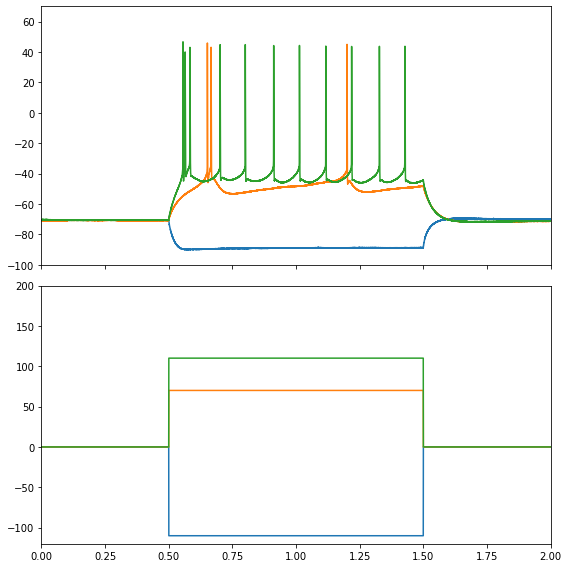

In [119]:
plot_trace(cell1_path)

/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999
indexes to be plotted: [0, 7, 8]


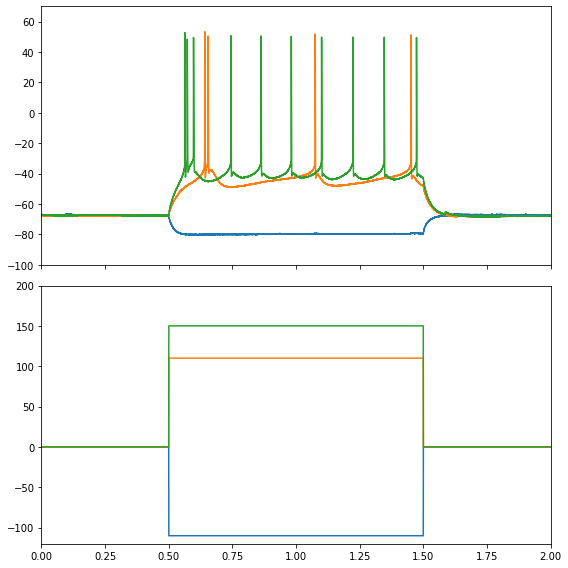

In [129]:
plot_trace(cell2_path)

## Plotting specific stimulation amplitudes that are shared between the 2 cells

In [184]:
data_set1 = create_ephys_data_set(nwb_file=cell1_path)
lsa_sweeps1 = process_dataset_sweeps(data_set1)
lsa_features1 = extract_features(lsa_sweeps1)

lsa_features1['sweeps']

/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999


,avg_rate,peak_deflect,stim_amp,v_baseline,sag,adapt,latency,isi_cv,mean_isi,median_isi,first_isi
0,0.00000,"(-90.09376, 54226)",-110.000000,-70.739548,0.058830,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00000,"(-87.5625, 55258)",-90.000000,-70.778564,0.049550,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00000,"(-85.09375, 56432)",-70.000000,-70.765900,0.058506,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00000,"(-82.4375, 86425)",-50.000000,-70.266266,0.092299,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00000,"(-77.25, 59098)",-29.999998,-70.034210,0.095038,NaN,NaN,NaN,NaN,NaN,NaN
5,0.00000,"(-54.968754, 99201)",50.000000,-70.443787,-34.477310,NaN,NaN,NaN,NaN,NaN,NaN
6,3.00006,"(45.906254, 58596)",70.000000,-70.851135,-41.886105,0.947867,0.15082,0.947867,0.274300,0.27430,0.01430
7,0.00000,"(-50.062504, 64324)",59.999996,-71.006485,-42.091404,NaN,NaN,NaN,NaN,NaN,NaN
8,11.00022,"(46.687504, 53804)",110.000000,-70.669403,-31.617584,0.114936,0.05496,0.428314,0.087196,0.10131,0.00824
9,17.00034,"(46.718754, 52748)",150.000000,-70.523964,-28.940203,0.066055,0.03384,0.323481,0.058801,0.06621,0.00782


In [185]:
data_set2 = create_ephys_data_set(nwb_file=cell2_path)
lsa_sweeps2= process_dataset_sweeps(data_set2)
lsa_features2 = extract_features(lsa_sweeps2)

lsa_features2['sweeps']

/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999


,avg_rate,peak_deflect,stim_amp,v_baseline,sag,adapt,latency,isi_cv,mean_isi,median_isi,first_isi
0,0.00000,"(-80.34375, 56326)",-110.000000,-67.490189,0.064268,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00000,"(-78.87501, 57910)",-90.000000,-67.491310,0.059331,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00000,"(-76.90626, 92698)",-70.000000,-68.070229,0.068583,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00000,"(-75.03125, 61921)",-50.000000,-68.301262,0.041631,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00000,"(-73.0625, 90998)",-29.999998,-68.612137,0.023101,NaN,NaN,NaN,NaN,NaN,NaN
5,0.00000,"(-46.718754, 64424)",100.000000,-67.346474,-31.154922,NaN,NaN,NaN,NaN,NaN,NaN
6,5.00010,"(52.187504, 57161)",119.999992,-67.768227,-32.932579,0.306323,0.12216,0.551054,0.206450,0.26638,0.01012
7,4.00008,"(53.375004, 58075)",110.000000,-67.854279,-34.436897,0.441988,0.14044,0.676155,0.270173,0.37652,0.01310
8,10.00020,"(52.71875, 54179)",150.000000,-67.669861,-35.156876,0.136716,0.06252,0.453764,0.101102,0.11914,0.00924
9,14.00028,"(51.812504, 53007)",190.000000,-67.495178,-14.937338,0.079005,0.03910,0.366001,0.068694,0.07734,0.00788


### The stim_amplitude values of -110, 110 and 150 are used in both cells, but have different indexes.

In [186]:
# Cell 1 indexes
most_hyp_sweep_index_c1 = lsa_features1['sweeps'].sort_values(by = ['stim_amp']).iloc[0].name
mid_sweep_index_c1 = lsa_features1['sweeps'][lsa_features1['sweeps'].stim_amp == 110].iloc[0].name
max_sweep_index_c1 = lsa_features1['sweeps'][lsa_features1['sweeps'].stim_amp == 150].iloc[0].name

sweep_plot_index_list_c1 = [most_hyp_sweep_index_c1, mid_sweep_index_c1, max_sweep_index_c1]



In [187]:
# Cell 2 indexes
most_hyp_sweep_index_c2 = lsa_features2['sweeps'].sort_values(by = ['stim_amp']).iloc[0].name
mid_sweep_index_c2 = lsa_features2['sweeps'][lsa_features2['sweeps'].stim_amp == 110].iloc[0].name
max_sweep_index_c2 = lsa_features2['sweeps'][lsa_features2['sweeps'].stim_amp == 150].iloc[0].name

sweep_plot_index_list_c2 = [most_hyp_sweep_index_c2, mid_sweep_index_c2, max_sweep_index_c2]



In [188]:
print(sweep_plot_index_list_c1)
print(sweep_plot_index_list_c2)

[0, 8, 9]
[0, 7, 8]


## Plot v2
- Plot 3 separate subplots on a single row: include both cells on a single plot and below show the stimulation.
- Add a frequency/current plot to summarize

In [189]:
for ix1, ix2 in zip(sweep_plot_index_list_c1, sweep_plot_index_list_c2):
    print(ix1, ix2)

0 0
8 7
9 8


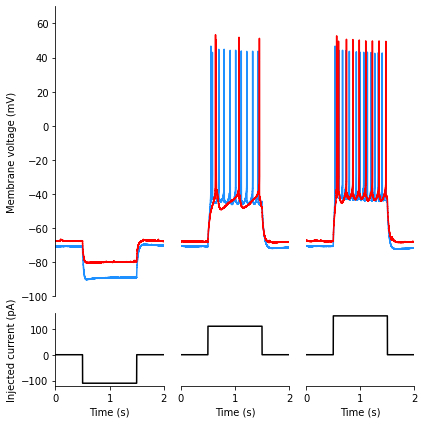

In [190]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=False, gridspec_kw={'height_ratios': [4, 1]}, figsize=(6,6))

for i, (sweep_ix1, sweep_ix2) in enumerate(zip(sweep_plot_index_list_c1, sweep_plot_index_list_c2)):
    cell_1_sweep = lsa_sweeps1.sweeps[sweep_ix1]
    cell_2_sweep = lsa_sweeps2.sweeps[sweep_ix2]
    axes[0][i].plot(cell_1_sweep.t, cell_1_sweep.v, color='dodgerblue')
    axes[0][i].plot(cell_2_sweep.t, cell_2_sweep.v, color='red')
    axes[1][i].plot(cell_1_sweep.t, cell_1_sweep.i, color='k')

#axes[0][0].set_title(f'{cell_1_id}')
#axes[0][1].set_title(f'{cell_2_id}')
        
axes[0][0].set_xlim(0, 2)
axes[0][1].set_xlim(0, 2)
axes[0][2].set_xlim(0, 2)
axes[1][0].set_xlim(0, 2)    
axes[1][1].set_xlim(0, 2)        
axes[1][2].set_xlim(0, 2)      

axes[0][0].set_ylim(-100, 70)
axes[0][1].set_ylim(-100, 70)
axes[0][2].set_ylim(-100, 70)
axes[1][0].set_ylim(-120, 160)
axes[1][1].set_ylim(-120, 160)
axes[1][2].set_ylim(-120, 160)

axes[0][0].set_ylabel("Membrane voltage (mV)")
axes[1][0].set_ylabel("Injected current (pA)")

axes[1][0].set_xlabel("Time (s)")
axes[1][1].set_xlabel("Time (s)")
axes[1][2].set_xlabel("Time (s)")

for ax in fig.get_axes():
    ax.label_outer()
    
axes[0][0].spines['top'].set_visible(False)
axes[0][0].spines['right'].set_visible(False)
axes[0][0].spines['bottom'].set_visible(False)
axes[0][0].set_xticks([])

axes[0][1].axis('off')
axes[0][2].axis('off')

axes[1][0].spines['top'].set_visible(False)
axes[1][0].spines['right'].set_visible(False)

axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)

axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)
axes[1][1].spines['left'].set_visible(False)
axes[1][1].set_yticks([])

axes[1][2].spines['top'].set_visible(False)
axes[1][2].spines['right'].set_visible(False)
axes[1][2].spines['left'].set_visible(False)
axes[1][2].set_yticks([])

plt.tight_layout()
fig.savefig(output_path/'trace_comparison_v2_human_pyr.svg', facecolor='w', dpi=300) 

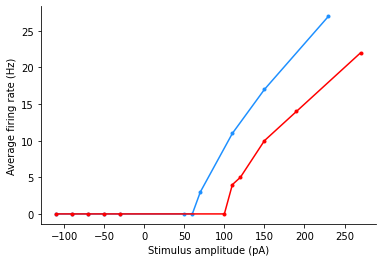

In [191]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(lsa_features1['sweeps'].sort_values('stim_amp')['stim_amp'], lsa_features1['sweeps'].sort_values('stim_amp')['avg_rate'], '.-', color='dodgerblue')
ax.plot(lsa_features2['sweeps'].sort_values('stim_amp')['stim_amp'], lsa_features2['sweeps'].sort_values('stim_amp')['avg_rate'], '.-', color='red')

ax.set_ylabel("Average firing rate (Hz)")
ax.set_xlabel("Stimulus amplitude (pA)")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(output_path/'fI_cell_comparison_human_pyr.svg', facecolor='w', dpi=300) 

### Now perform analysis on two example Pvalb Sema3e cells

In [192]:
cell_1_id = '892441714'
cell_2_id = '892424119'

cell1_path = 'data/ephys/sub-885375443_ses-892441714_icephys.nwb'
cell2_path = 'data/ephys/sub-885375443_ses-892424119_icephys.nwb'

In [193]:
data_set1 = create_ephys_data_set(nwb_file=cell1_path)
lsa_sweeps1 = process_dataset_sweeps(data_set1)
lsa_features1 = extract_features(lsa_sweeps1)
lsa_features1['sweeps']

/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999


,avg_rate,peak_deflect,stim_amp,v_baseline,sag,adapt,latency,isi_cv,mean_isi,median_isi,first_isi
0,0.00000,"(-74.65626, 32728)",-29.999998,-69.561386,0.092983,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00000,"(-77.606255, 32186)",-50.000000,-69.533287,0.050307,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00000,"(-80.443756, 32706)",-70.000000,-69.630936,0.064806,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00000,"(-83.23125, 32350)",-90.000000,-69.606110,0.067157,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00000,"(-85.7, 32132)",-110.000000,-69.618660,0.075032,NaN,NaN,NaN,NaN,NaN,NaN
5,5.00010,"(24.375002, 36835)",190.000000,-70.296989,-10.788184,0.115615,0.05924,0.483122,0.057850,0.05095,0.05000
6,0.00000,"(-35.762505, 39319)",180.000000,-69.470200,-10.487164,NaN,NaN,NaN,NaN,NaN,NaN
7,19.00038,"(23.400002, 38319)",210.000000,-69.810860,-11.037130,0.006236,0.03898,0.202305,0.024870,0.02398,0.02268
8,43.00086,"(24.431252, 41485)",230.000000,-70.259590,-8.261668,0.003938,0.01590,0.880452,0.022835,0.01943,0.01936
9,64.00128,"(24.89375, 30563)",249.999985,-70.473511,-7.698266,0.002470,0.01024,0.219314,0.015415,0.01496,0.01510


In [194]:
data_set2 = create_ephys_data_set(nwb_file=cell2_path)
lsa_sweeps2= process_dataset_sweeps(data_set2)
lsa_features2 = extract_features(lsa_sweeps2)
lsa_features2['sweeps']

/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/nethome/kcni/stripathy/.local/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999


,avg_rate,peak_deflect,stim_amp,v_baseline,sag,adapt,latency,isi_cv,mean_isi,median_isi,first_isi
0,0.00000,"(-68.46251, 37539)",-29.999998,-64.864365,0.069136,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00000,"(-70.94375, 36136)",-50.000000,-65.021111,0.075599,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00000,"(-72.887505, 33211)",-70.000000,-64.523834,0.044086,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00000,"(-74.90001, 32284)",-90.000000,-64.746964,0.031924,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00000,"(-76.96875, 33643)",-110.000000,-64.961540,0.038577,NaN,NaN,NaN,NaN,NaN,NaN
5,2.00004,"(32.24375, 33451)",230.000000,-64.409378,-12.777286,NaN,0.03714,0.000000,0.030880,0.03088,0.03088
6,0.00000,"(-28.993752, 33849)",220.000000,-64.170891,-12.134620,NaN,NaN,NaN,NaN,NaN,NaN
7,4.00008,"(30.7125, 35933)",249.999985,-64.466759,-13.475342,-0.022320,0.04440,0.036435,0.024427,0.02442,0.02552
8,10.00020,"(31.237501, 34286)",270.000000,-65.437019,-11.794756,0.015819,0.02444,0.180345,0.017824,0.01636,0.01584
9,14.00028,"(31.449999, 30824)",290.000000,-65.373672,-11.064417,-0.000880,0.01544,0.127859,0.014342,0.01450,0.01630


In [195]:
# we'll use the 0th, 8th, and 9th sweeps from the first cell, and 
# 0th, 5th, and 7th sweeps from second cell, as they
# both correspond to -30, 230, and 250 pA of current injection
sweep_plot_index_list_c1 = [0, 8, 9]
sweep_plot_index_list_c2 = [0, 5, 7]


In [196]:
for ix1, ix2 in zip(sweep_plot_index_list_c1, sweep_plot_index_list_c2):
    print(ix1, ix2)

0 0
8 5
9 7


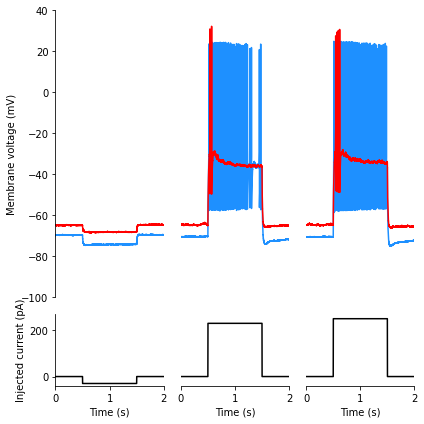

In [197]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=False, gridspec_kw={'height_ratios': [4, 1]}, figsize=(6,6))

for i, (sweep_ix1, sweep_ix2) in enumerate(zip(sweep_plot_index_list_c1, sweep_plot_index_list_c2)):
    cell_1_sweep = lsa_sweeps1.sweeps[sweep_ix1]
    cell_2_sweep = lsa_sweeps2.sweeps[sweep_ix2]
    axes[0][i].plot(cell_1_sweep.t, cell_1_sweep.v, color='dodgerblue')
    axes[0][i].plot(cell_2_sweep.t, cell_2_sweep.v, color='red')
    axes[1][i].plot(cell_1_sweep.t, cell_1_sweep.i, color='k')

#axes[0][0].set_title(f'{cell_1_id}')
#axes[0][1].set_title(f'{cell_2_id}')
        
axes[0][0].set_xlim(0, 2)
axes[0][1].set_xlim(0, 2)
axes[0][2].set_xlim(0, 2)
axes[1][0].set_xlim(0, 2)    
axes[1][1].set_xlim(0, 2)        
axes[1][2].set_xlim(0, 2)      

axes[0][0].set_ylim(-100, 40)
axes[0][1].set_ylim(-100, 40)
axes[0][2].set_ylim(-100, 40)
axes[1][0].set_ylim(-40, 270)
axes[1][1].set_ylim(-40, 270)
axes[1][2].set_ylim(-40, 270)

axes[0][0].set_ylabel("Membrane voltage (mV)")
axes[1][0].set_ylabel("Injected current (pA)")

axes[1][0].set_xlabel("Time (s)")
axes[1][1].set_xlabel("Time (s)")
axes[1][2].set_xlabel("Time (s)")

for ax in fig.get_axes():
    ax.label_outer()
    
axes[0][0].spines['top'].set_visible(False)
axes[0][0].spines['right'].set_visible(False)
axes[0][0].spines['bottom'].set_visible(False)
axes[0][0].set_xticks([])

axes[0][1].axis('off')
axes[0][2].axis('off')

axes[1][0].spines['top'].set_visible(False)
axes[1][0].spines['right'].set_visible(False)

axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)

axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)
axes[1][1].spines['left'].set_visible(False)
axes[1][1].set_yticks([])

axes[1][2].spines['top'].set_visible(False)
axes[1][2].spines['right'].set_visible(False)
axes[1][2].spines['left'].set_visible(False)
axes[1][2].set_yticks([])

plt.tight_layout()
fig.savefig(output_path/'trace_comparison_v2_pv_cells.svg', facecolor='w', dpi=300) 

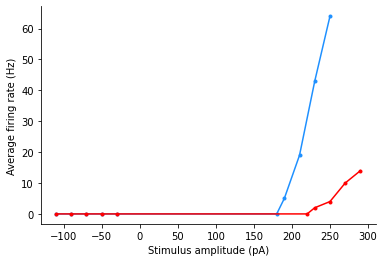

In [198]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(lsa_features1['sweeps'].sort_values('stim_amp')['stim_amp'], lsa_features1['sweeps'].sort_values('stim_amp')['avg_rate'], '.-', color='dodgerblue')
ax.plot(lsa_features2['sweeps'].sort_values('stim_amp')['stim_amp'], lsa_features2['sweeps'].sort_values('stim_amp')['avg_rate'], '.-', color='red')

ax.set_ylabel("Average firing rate (Hz)")
ax.set_xlabel("Stimulus amplitude (pA)")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(output_path/'fI_cell_comparison_pv_cells.svg', facecolor='w', dpi=300) 